In [2]:
import typing

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [3]:
seq_df = pd.read_csv('gs://pitch-sequencing/sequence_data/large_sequence_data_cur_opt.csv')
raw_df = pd.read_csv('../../data/raw_data_curmap.csv')

In [7]:
raw_df.head(5)

,game_date,pitch_number,batter,pitcher,balls,strikes,type,pitch_type,events,at_bat_number,player_name
0,2017-04-02,1,543305,643493,0,0,S,CB,NaN,76,"Pruitt, Austin"
1,2017-04-02,2,543305,643493,0,1,B,CH,NaN,76,"Pruitt, Austin"
2,2017-04-02,3,543305,643493,1,1,B,SI,NaN,76,"Pruitt, Austin"
3,2017-04-02,4,543305,643493,2,1,X,SI,single,76,"Pruitt, Austin"
4,2017-04-02,1,474892,517008,0,0,S,FC,NaN,77,"Colomé, Alex"


In [5]:
seq_df.head(5)

,Pitch Sequence,Pitcher ID,At-Bat Outcome
0,"FF,SL,FF,FF,SL",502042,field_out
1,"FF,SL,FF,SL",502042,strikeout
2,"FF,FF,SL",502042,field_out
3,"FF,FF,CH,FF",543144,strikeout
4,"CB,SI,CH,CH",452657,strikeout


In [9]:
raw_df['pitch_type'].value_counts(normalize=True)

pitch_type
FF    0.346335
SI    0.169459
SL    0.167190
CH    0.108277
CB    0.104803
FC    0.066759
ST    0.019256
FS    0.017013
KN    0.000822
PO    0.000086
Name: proportion, dtype: float64

In [10]:
seq_df['FirstPitch'] = seq_df['Pitch Sequence'].str.split(',').str[0]
seq_df['LastPitch'] = seq_df['Pitch Sequence'].str.split(',').str[-1]

In [11]:
seq_df['FirstPitch'].value_counts(normalize=True)

FirstPitch
FF    0.362296
SI    0.196761
SL    0.153526
CB    0.121856
CH    0.071864
FC    0.066095
ST    0.017396
FS    0.009188
KN    0.000888
PO    0.000131
Name: proportion, dtype: float64

In [12]:
seq_df['LastPitch'].value_counts(normalize=True)

LastPitch
FF    0.331796
SI    0.180846
SL    0.168911
CH    0.116125
CB    0.095852
FC    0.067169
ST    0.019335
FS    0.019082
KN    0.000864
PO    0.000020
Name: proportion, dtype: float64

In [15]:
seq_df['SeqLen'] = seq_df['Pitch Sequence'].str.split(',').str.len()

In [16]:
seq_df.head(10)

,Pitch Sequence,Pitcher ID,At-Bat Outcome,FirstPitch,LastPitch,SeqLen
0,"FF,SL,FF,FF,SL",502042,field_out,FF,SL,5
1,"FF,SL,FF,SL",502042,strikeout,FF,SL,4
2,"FF,FF,SL",502042,field_out,FF,SL,3
3,"FF,FF,CH,FF",543144,strikeout,FF,FF,4
4,"CB,SI,CH,CH",452657,strikeout,CB,CH,4
5,"SI,CH,CH,FC,SI,FF",452657,strikeout,SI,FF,6
6,"SI,FF,FF,CH",452657,strikeout,SI,CH,4
7,"FS,FS,FF",493157,single,FS,FF,3
8,FF,453343,double,FF,FF,1
9,"FF,FF,FC,FC,CB",518516,field_out,FF,CB,5


In [18]:
print(f"Mean Sequence Length {seq_df['SeqLen'].mean()}")
print(f"Median Sequence Length {seq_df['SeqLen'].median()}")

Mean Sequence Length 3.9055074479207095
Median Sequence Length 4.0


In [22]:
seq_df['SeqLen'].value_counts().sort_index()

SeqLen
1     134012
2     180342
3     216397
4     227418
5     205521
6     145207
7      62376
8      25056
9       9220
10      3531
11      1163
12       458
13       150
14        63
15        14
16         8
17         4
19         1
21         1
Name: count, dtype: int64

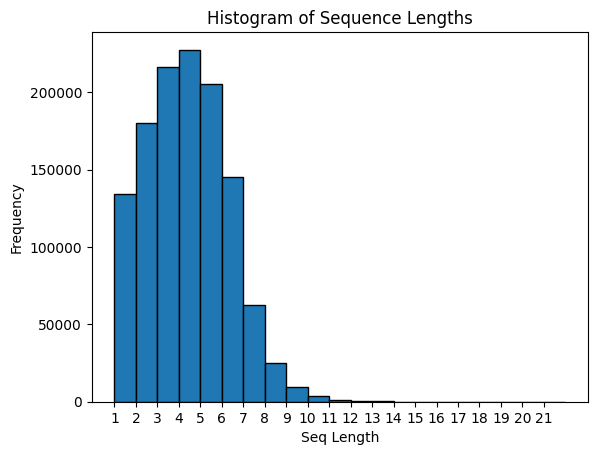

In [20]:
import matplotlib.pyplot as plt

# Generate a histogram
plt.hist(seq_df['SeqLen'], bins=range(1, seq_df['SeqLen'].max() + 2), edgecolor='black')
plt.title('Histogram of Sequence Lengths')
plt.xlabel('Seq Length')
plt.ylabel('Frequency')
plt.xticks(range(1, seq_df['SeqLen'].max() + 1))  # Set x-ticks to be integer values of list lengths
plt.show()

# Now let's train a model.

### First generate some data splits

In [26]:
# Drop sequences that are greater than 1 pitch
seq_df_to_export = seq_df[seq_df["SeqLen"] > 1]
seq_df_to_export = seq_df.drop(["LastPitch", "FirstPitch", "SeqLen"], axis=1)

In [27]:
# 70/20/10 Split
train_df, temp_df = train_test_split(seq_df_to_export, test_size=0.3, random_state=42)
validation_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=42)  

In [28]:
train_df.to_csv('gs://pitch-sequencing/sequence_data/last_pitch_prediction/large_cur_train.csv', index=False)
validation_df.to_csv('gs://pitch-sequencing/sequence_data/last_pitch_prediction/large_cur_validation.csv', index=False)
test_df.to_csv('gs://pitch-sequencing/sequence_data/last_pitch_prediction/large_cur_test.csv', index=False)